In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import math
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense, LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

Using TensorFlow backend.


In [3]:
dataframe = pd.read_csv('../01.data/PeopleCountData_wide.txt',sep='|')
dataframe['timestamp'] = pd.to_datetime(dataframe.timestamp)
dataframe['date'] = dataframe.timestamp.dt.date
dataframe['hour'] = dataframe.timestamp.dt.hour

In [4]:
dataframe.head(2)

,timestamp,incoming_DouglassBridge,incoming_FriedlanderLobby,incoming_GleasonEntrance,incoming_GleasonStacks,outgoing_DouglassBridge,outgoing_FriedlanderLobby,outgoing_GleasonEntrance,outgoing_GleasonStacks,date,hour
0,2017-05-04 15:53:00,5.0,6.0,3.0,2.0,4.0,4.0,5.0,6.0,2017-05-04,15
1,2017-05-04 15:54:00,2.0,1.0,1.0,1.0,1.0,8.0,2.0,1.0,2017-05-04,15


## LSTM Network for Regression

In [5]:
cols_to_drop = ['timestamp', 'hour']

In [6]:
# fix random seed for reproducibility

np.random.seed(7)

for column in cols_to_drop:
    del dataframe[column]
    
# load the dataset

dataframe_grouped = dataframe.groupby('date').sum()
dataframe_grouped['weekday'] = pd.to_datetime(dataframe_grouped.index).weekday

mu = dataframe_grouped[(dataframe_grouped<4000)].mean(0)['outgoing_DouglassBridge']
dataframe_grouped.outgoing_DouglassBridge.loc[dataframe_grouped.outgoing_DouglassBridge>4000] = mu


dataset = dataframe_grouped.values
dataset = dataset.astype('float32')

/home/npatil4/.local/lib/python2.7/site-packages/pandas/core/indexing.py:179: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [8]:
# normalize the dataset

scaler = MinMaxScaler(feature_range=(0, 1))
dataset[:,:-1] = scaler.fit_transform(dataset[:,:-1])

In [9]:
# split into train and test sets

train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

train.shape,test.shape

((176, 9), (88, 9))

In [13]:
# convert an array of values into a dataset matrix

def create_dataset(dataset_in, look_back=1):
    
    dataX, dataY = [], []
    
    for i in range(len(dataset_in)-look_back-1):
        
        a = dataset_in[i:(i+look_back), :]
        dataX.append(a)
        dataY.append(dataset_in[i + look_back, :-1])
        
    return np.array(dataX), np.array(dataY)

In [15]:
# reshape into X=t and Y=t+1

look_back = 7

trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

trainX.shape, trainY.shape,testX.shape, testY.shape

((168, 7, 9), (168, 8), (80, 7, 9), (80, 8))

In [16]:
run = '04_128_nodes'

In [17]:
from keras.callbacks import EarlyStopping,ModelCheckpoint

ES = EarlyStopping(patience=20)

MC = ModelCheckpoint(filepath='../05.model/model_'+run+'.h5')

In [18]:
from keras.layers import Dropout
from keras.optimizers import Adam
from keras import backend as K

batch_size = 1

# create and fit the LSTM network

K.clear_session()
input_shape = ((trainX.shape[1],trainX.shape[-1]))
num_classes = trainY.shape[-1]

model = Sequential()

model.add(LSTM(units = 128, input_shape = input_shape))

model.add(Dense(num_classes))

model.compile(loss='mse', optimizer='adam')

In [19]:
model.fit(trainX, trainY, 
          epochs=1000, 
          batch_size=batch_size,
          validation_split=0.1,
          callbacks=[ES,MC], verbose=2, 
          shuffle=False)

model.save('../05.model/model_'+run+'.h5')

Train on 151 samples, validate on 17 samples
Epoch 1/1000
 - 15s - loss: 0.0163 - val_loss: 0.0974
Epoch 2/1000
 - 2s - loss: 0.0144 - val_loss: 0.0451
Epoch 3/1000
 - 2s - loss: 0.0182 - val_loss: 0.0498
Epoch 4/1000
 - 2s - loss: 0.0173 - val_loss: 0.0221
Epoch 5/1000
 - 2s - loss: 0.0177 - val_loss: 0.0217
Epoch 6/1000
 - 2s - loss: 0.0161 - val_loss: 0.0199
Epoch 7/1000
 - 2s - loss: 0.0146 - val_loss: 0.0179
Epoch 8/1000
 - 2s - loss: 0.0138 - val_loss: 0.0155
Epoch 9/1000
 - 2s - loss: 0.0133 - val_loss: 0.0133
Epoch 10/1000
 - 2s - loss: 0.0129 - val_loss: 0.0118
Epoch 11/1000
 - 2s - loss: 0.0122 - val_loss: 0.0112
Epoch 12/1000
 - 2s - loss: 0.0115 - val_loss: 0.0106
Epoch 13/1000
 - 2s - loss: 0.0110 - val_loss: 0.0108
Epoch 14/1000
 - 2s - loss: 0.0106 - val_loss: 0.0109
Epoch 15/1000
 - 2s - loss: 0.0103 - val_loss: 0.0112
Epoch 16/1000
 - 2s - loss: 0.0099 - val_loss: 0.0111
Epoch 17/1000
 - 2s - loss: 0.0096 - val_loss: 0.0107
Epoch 18/1000
 - 2s - loss: 0.0092 - val_loss

In [20]:
from keras.models import load_model
model = load_model('../05.model/model_'+run+'.h5')

# make predictions

trainPredict = model.predict(trainX, batch_size=batch_size)
model.reset_states()

testPredict = model.predict(testX, batch_size=batch_size)

# invert predictions

trainPredict = scaler.inverse_transform(trainPredict)
trainY_actual = scaler.inverse_transform(trainY)
testPredict = scaler.inverse_transform(testPredict)
testY_actual = scaler.inverse_transform(testY)


# calculate root mean squared error

trainScore = math.sqrt(mean_squared_error(trainY_actual, trainPredict))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY_actual, testPredict))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 225.06 RMSE
Test Score: 380.99 RMSE


In [21]:
# make predictions

trainPredict = model.predict(trainX, batch_size=batch_size)

testPredict = model.predict(testX, batch_size=batch_size)

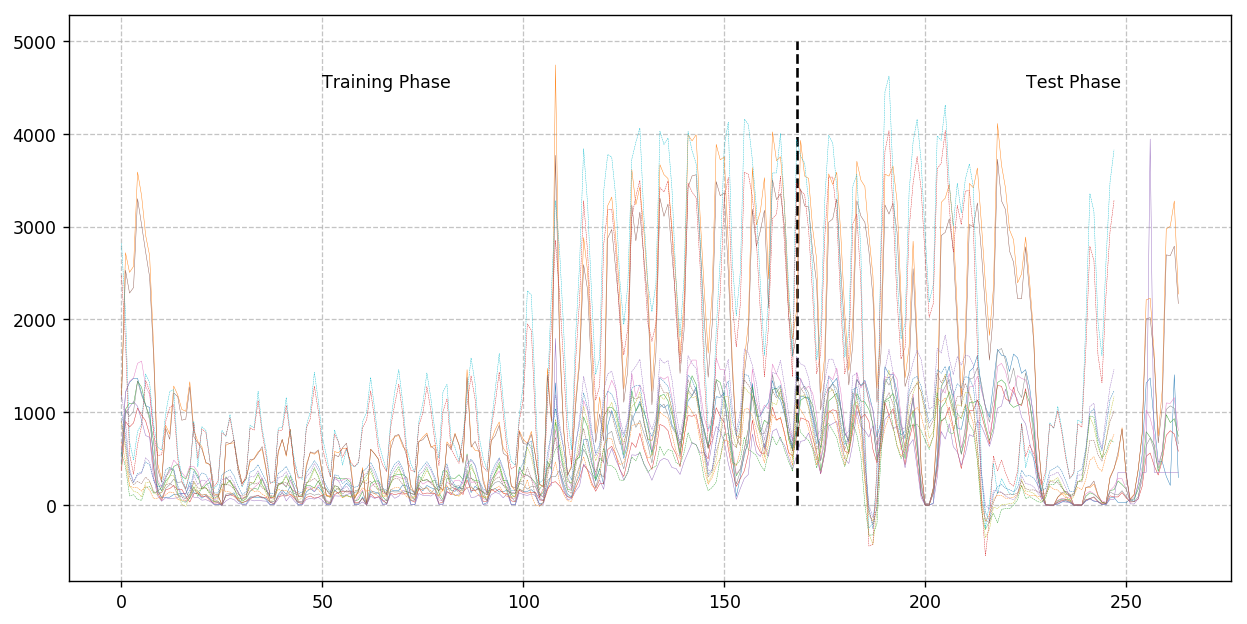

In [22]:
# plot baseline and predictions

actualPlot = scaler.inverse_transform(dataset[:,:-1])
predictPlot = scaler.inverse_transform(np.concatenate([trainPredict,testPredict]))

plt.figure(figsize=(12,6),dpi=125)
plt.plot(actualPlot, ls='-', lw=0.25)
plt.plot(predictPlot, ls='--', lw=0.25)
plt.vlines(x = trainX.shape[0], ymin=0, ymax=5000, linestyles='dashed')
#plt.axis([0,260,0,5000])
plt.grid(ls='--',lw=0.75,alpha=0.75)
plt.text(50,4500,'Training Phase')
plt.text(225,4500,'Test Phase');